# Master Thesis in Economics
University of Copenhagen summer 2024

Authors: Cecilie Brøchner & Emma Vorregaard

Supervisor:  Heino Bohn Nielsen

Research question

Does the combination of non-linear econometric models and machine learning techniques improve the predictability of economic or financial downturns compared to more traditional econometric models?

Description

The purpose of our master thesis is to develop a model that combines non-linear models (such as probit, logit or Markov-switching regression models) with machine learning (possibly deep neural networks) in order to predict economic or financial downturns. Traditional econometric models often face limitations with complex and large datasets where machine learning, however, is highly effective in handling big data and predict the outcomes hereof. We seek to improve the ability to anticipate and prepare for economic downturns utilizing the accuracy, reliability, and early warning capabilities of machine learning using economic and financial theory to select and gather time series data on economic indicators thereof. 

Throughout our research and paper, we draw inspiration from the following papers “Hidden Markov models as recurrent neural networks: an application to Alzheimer's disease” by Matt Baucum, Anahita Khojandi, Theodore Papamarkou, “China's GDP forecasting using Long Short Term Memory Recurrent Network and Hidden Markov Model” by Hunhuan Zhang, Jiaqi Wen, Zhen Yang and “Predicting US recessions with leading indicators via neural network models” by Min Qi with more to come.

Relevance: Forecasting future Time Series values is a quite common problem in practice. Time Series data introduces a “hard dependency” on previous time steps, so the assumption that independence of observations doesn’t hold.

In [22]:
# import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
import tensorflow as tf
from tensorflow import keras
import warnings
import sys

# import our own functions
sys.path.append("/Users/emmavorregaard/Desktop/Speciale")
import myfunctions as func

# plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 8, 5

# set seed
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# other
warnings.filterwarnings('ignore')
#os.environ['MKL_THREADING_LAYER'] = 'GNU'
tf.config.set_visible_devices([], 'GPU')  # This forces TensorFlow to use CPU only

# Data

## Import

Data is from Federal Reserve Economic Data (FRED). It is the quarterly database for macroeconomic research (FRED-QD). The database is updated in real time using the FRED database. A full description of data can be found here:

https://s3.amazonaws.com/real.stlouisfed.org/wp/2020/2020-005.pdf

https://files.stlouisfed.org/files/htdocs/publications/review/2021/01/14/fred-qd-a-quarterly-database-for-macroeconomic-research.pdf

The database covers the period of 1959-Q1 to 2023-Q4.

In [23]:
# import data
macro_data = pd.read_csv("macro_data.csv")
macro_data = macro_data.iloc[2:].reset_index(drop=True) # removes irrelevant rows
macro_data.head()

sasdate     GDPC1   PCECC96    PCDGx     PCESVx     PCNDx   GPDIC1  \
0   3/1/1959  3352.129  2039.017  68.6651  1374.1739  689.1172  354.894   
1   6/1/1959  3427.667  2070.508  71.2495  1394.7096  694.8197  382.500   
2   9/1/1959  3430.057  2092.138  72.6270  1413.6627  697.4699  357.798   
3  12/1/1959  3439.832  2094.495  69.1573  1430.8157  701.7617  369.442   
4   3/1/1960  3517.181  2114.532  71.3815  1443.7405  703.5338  406.581   

       FPIx  Y033RC1Q027SBEAx     PNFIx  ...   TLBSNNBx  TLBSNNBBDIx  \
0  357.0174           47.8021  171.0783  ...  333245.24    266668.11   
1  368.0640           49.2332  176.0004  ...  345845.01    273329.36   
2  371.9585           50.8372  180.7406  ...  354808.05    275139.48   
3  367.6452           50.7342  180.2333  ...  349400.81    254967.79   
4  379.9162           52.4985  186.4967  ...  362821.95    278692.55   

     TABSNNBx  TNWBSNNBx  TNWBSNNBBDIx     CNCFx  S&P 500  S&P: indust  \
0  2426352.41    2092.54       1674.48  124.9663  55.5167      59.1400   
1  2434975.21    2088.55       1650.63  126.5305  57.5067      61.5867   
2  2434604.03    2079.21       1612.34  128.9557  58.7300      63.0600   
3  2429055.21    2079.05       1517.14  137.0372  57.7633      62.0200   
4  2451394.44    2087.97       1603.82  130.1872  56.2767      60.1933   

   S&P div yield  S&P PE ratio  
0         3.1765       18.6211  
1         3.1012       19.2899  
2         3.0720       18.9544  
3         3.1572       17.8221  
4         3.3850       16.8284  

[5 rows x 247 columns]

## Data Preprocessing

Before using the data we need to 
- drop irrelevant columns
- handle missing values
- transform series so that they are stationary i.e. mean zero and variance one
- normalize/standardize data i.e. series need to be on the same scale

### Drop columns

We excludes some columns from the beginning based on their mikro level. We exclude based on 

- Group 3: Employment
    - not interested in duration of employment and unemployment
    - not interested in age
    - not interested in sex
    - not interested in how many entries and exits the labour force (we include participation rate)
    - not interested in average hours of the production and nonsupervisory employees 

- Group 4: Housing
    - not interested in regional effects

- Group 6: Prices 
    - not interested in sub-sub-categories for the prices indexes

- Group 7: Earning and Productivity
    - not interested in average hours of production of the production and nonsupervisory employees 

- Group 9: Money and Credit
    - not interested in M1

In [24]:
# import appendix that contains IDs
appendix_data = pd.read_csv("FRED-QD_updated_appendix.csv", sep=";", encoding='unicode_escape')
appendix_data.head()

ID SW ID  TCODE  SW Factors FRED MNEMONIC  SW MNEMONIC  \
0   1     1      5           0         GDPC1          GDP   
1   2     2      5           0       PCECC96  Consumption   
2   3     3      5           1         PCDGx     Cons:Dur   
3   4     4      5           1        PCESVx     Cons:Svc   
4   5     5      5           1         PCNDx  Cons:NonDur   

                                         DESCRIPTION  Group  
0  Real Gross Domestic Product, 3 Decimal (Billio...      1  
1  Real Personal Consumption Expenditures (Billio...      1  
2  Real personal consumption expenditures: Durabl...      1  
3  Real Personal Consumption Expenditures: Servic...      1  
4  Real Personal Consumption Expenditures: Nondur...      1

In [25]:
# define the ranges of IDs to drop (inclusive)
id_ranges_to_drop = [
    range(60, 73), # employment
    range(77, 80), # employment
    range(84, 88), # housing
    range(104, 115), # prices
    range(131, 134), # earnings and productivity
    range(197, 201), # employment
    range(227, 231), # housing
    [117, 160, 206, 216] # prices, M1 and earnings and productivity
]

# create list
ids_to_drop = [id for subrange in id_ranges_to_drop for id in subrange]
print(ids_to_drop)

# drop
appendix_data_cleaned = appendix_data[~appendix_data['ID'].isin(ids_to_drop)]

# use the cleaned appendix to filter on macro_data
variables_to_keep = list(appendix_data_cleaned['FRED MNEMONIC'].dropna().unique())
variables_to_keep.insert(0, 'sasdate')

# filter on macro_data
macro_data_filtered = macro_data[variables_to_keep]

[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 77, 78, 79, 84, 85, 86, 87, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 131, 132, 133, 197, 198, 199, 200, 227, 228, 229, 230, 117, 160, 206, 216]


### Time period

We are interested in the period starting from 1984Q1 (we include 1982Q3 as we later on do some transformations and include the fourth lag of your regressors)

In [26]:
macro_data_filtered['sasdate'] = pd.to_datetime(macro_data_filtered['sasdate'])
macro_data_short = macro_data_filtered[macro_data_filtered['sasdate']>'1982-06-01']

# define period
start_date = '1984-01-01'
end_date = '2019-12-31'

### Missing Values
Continuity in data is important for our models.

We notice that multiple variables are missing an observation for the last period (2023-Q4) so we drop that row before handling the rest of the missing values.

In [27]:
# remove two latest observations
macro_data_short = macro_data_short[:-2]

In [28]:
# calculate missing values for each column
total_missing = macro_data_short.isnull().sum()

# initialize DataFrame to store results
missing_details = pd.DataFrame(total_missing, columns=['Total_Missing'])

# determine where missing values occur
missing_details['Beginning'] = macro_data_short.iloc[:1].isnull().any()
missing_details['End'] = macro_data_short.iloc[-1:].isnull().any()

# create a function to classify the location of missing values
def classify_missing(beginning, end):
    if beginning and end:
        return 'Both'
    elif beginning:
        return 'Beginning'
    elif end:
        return 'End'
    else:
        return 'None'

# apply the classification function
missing_details['Missing_Location'] = missing_details.apply(
    lambda row: classify_missing(row['Beginning'], row['End']), axis=1)

# drop
missing_details.drop(['Beginning', 'End'], axis=1, inplace=True)

# display
missing_details = missing_details[missing_details['Missing_Location']!='None']

# split
missing_details_both = missing_details[missing_details['Missing_Location']=='Both'] # no variable has missing value in beginning and end
missing_details_end = missing_details[missing_details['Missing_Location']=='End'] # no variable has missing value in end
missing_details_beginning = missing_details[missing_details['Missing_Location']=='Beginning']

missing_details_beginning['Years'] = missing_details_beginning['Total_Missing']/4
missing_details_beginning

Total_Missing Missing_Location  Years
OUTMS                     18        Beginning    4.5
HOAMS                     18        Beginning    4.5
RSAFSx                    38        Beginning    9.5
ACOGNOx                   38        Beginning    9.5
OILPRICEx                 14        Beginning    3.5
COMPRMS                   18        Beginning    4.5
OPHMFG                    18        Beginning    4.5
ULCMFG                    18        Beginning    4.5
CPF3MTB3Mx                58        Beginning   14.5
SPCS10RSA                 18        Beginning    4.5
SPCS20RSA                 70        Beginning   17.5
TWEXAFEGSMTHx             94        Beginning   23.5
EXUSEU                    66        Beginning   16.5
USEPUINDXM                10        Beginning    2.5
CP3M                      58        Beginning   14.5
COMPAPFF                  58        Beginning   14.5
CUSR0000SEHC               2        Beginning    0.5

In [29]:
# for now we leave these variables out in order to obtain as many observations as possible

# list of variables to drop
variables_to_drop = list(missing_details_beginning.index.values)

# Drop the columns from the DataFrame
macro_data_short.drop(columns=variables_to_drop, inplace=True, errors='ignore')

# check for missing values
print('Number of missing values is ' + str(macro_data_short.isnull().sum().sum()))

Number of missing values is 0


### Transformations
A Times Series is said to be stationary when the mean and variance remain constant over time. A Time Series has a trend if the mean is varying over time. Often you can eliminate it and make the series stationary by applying log transformation(s).

In appendix to the database we find descriptions and data transformations for the series. The column "tcode" tells how to transform the series to that they are stationary. 

It consists of the following data transformations:

1. No transformation
2. $Δx_t$
3. $Δx_t-Δx_{t-1}$
4. $\log(x_t)$
5. $\Delta\log(x_t)$
6. $Δ\log(x_t)-Δ\log(x_{t-1})$
7. $\Delta(x_t/x_{t-1}-1)$

In [30]:
# reshape data into long format
macro_data_long = macro_data_short.melt(id_vars=['sasdate'])
macro_data_long['sasdate'] = pd.to_datetime(macro_data_long['sasdate'])

# make a new dataframe with variables and their transformation codes
appendix_data_sub = appendix_data[['FRED MNEMONIC','TCODE']]

# join TCODE onto data
macro_data_long = macro_data_long.merge(appendix_data_sub, left_on='variable', right_on='FRED MNEMONIC')

macro_data_long.set_index('sasdate', inplace=True)

In [31]:
# add column that combines tcode and description
appendix_data['DESCRIPTION'] = appendix_data['DESCRIPTION'].str.replace('/','to')
appendix_data["code_and_name"] = "tcode " + appendix_data['TCODE'].astype(str) + " - " + appendix_data['DESCRIPTION'].astype(str)

In [28]:
# define transformation function
def transform_all(series):
    return {
        'Original': series,
        '1. Diff': series.diff(),
        '2. Diff': series.diff().diff(),
        'Log': np.log(series.replace(0, np.nan)),
        '1. Diff of Log': np.log(series.replace(0, np.nan)).diff(),
        '1. Diff of Log - lag(1. Diff of Log)': np.log(series.replace(0, np.nan)).diff() - np.log(series.replace(0, np.nan)).diff().shift(1),
        '1. Diff of the Rate of Change': (series / series.shift(1) - 1).diff()
    }

# plotting
plot_directory = 'macro_plots'
os.makedirs(plot_directory, exist_ok=True)
titles_dict = titles_dict = appendix_data.set_index('FRED MNEMONIC')["code_and_name"].to_dict()

for series_code in macro_data_long['variable'].unique():
    series_data = macro_data_long[macro_data_long['variable'] == series_code]['value'].dropna()
    transformations = transform_all(series_data)

    fig, axes = plt.subplots(4, 2, figsize=(12, 10), tight_layout=True)
    fig.suptitle(titles_dict.get(series_code, 'Unknown Series'))

    for ax, (transform_name, transformed_data) in zip(axes.flatten(), transformations.items()):
        if transformed_data.dropna().empty or transformed_data.var() < 1e-10:  # Check for empty or near-constant data
            ax.text(0.5, 0.5, 'Insufficient data or data is constant', horizontalalignment='center', verticalalignment='center')
            ax.set_title(transform_name)
            continue

        try:
            result = adfuller(transformed_data.dropna())
            p_value = result[1]
            ax.plot(transformed_data)
            ax.set_title(f'{transform_name} (p-value: {p_value:.4f})')
            ax.tick_params(axis='x', rotation=45)
        except Exception as e:
            ax.text(0.5, 0.5, str(e), horizontalalignment='center', verticalalignment='center')
            ax.set_title(transform_name)

    plt.savefig(f"{plot_directory}/{titles_dict.get(series_code, series_code)}.png")
    plt.close()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [32]:
# updating tranformation codes
tcode_updates = {
    'CPIAPPSL': 5,
    'CPIAUCL': 5,
    'CPIFESL': 5,
    'CPITRNSL': 5,
    'CUMFNS': 2,
    'CUS0000SA0L2': 5,
    'CUS0000SA0L5': 5,
    'CUS0000SAC': 5,
    'CUS0000SAD': 5,
    'CUS0000SAS': 5,
    'CUMFNS': 2,
    'DDURRG3Q086SBEA': 5,
    'DGDSRG3Q086SBEA': 5,
    'DIFSRG3Q086SBEA': 5,
    'DNDRG3Q086SBEA': 5,
    'DOTSRG3Q086SBEA': 5,
    'DRCARG3Q086SBEA': 5,
    'DSERRG3Q086SBEA': 5,
    'DTCOLNVHFNFM': 5,
    'DTCTHFNFM': 5,
    'DTRSRG3Q086SBEA': 5,
    'GPDICTPI': 5,
    'GS1TB3Mx':2,
    'HWIx': 5,
    'INVEST': 5,
    'LIABPIx': 6,
    'NWPIx': 2,
    'PCECTPI': 5,
    'PPIACO': 5,
    'PPIIDC': 5,
    'REALLNx': 6,
    'TLBSNNBBDIx': 2,
    'TLBSHNOx': 6,
    'UMCSENTx': 5,
    'UNRATE': 1,
    'WPSFD4111': 5,
    'WPSFD49207': 5,
    'WPSFD49502': 5,
    'WPSID61': 5,
    'WPSID62': 5
}

# update TCODEs
for variable, new_tcode in tcode_updates.items():
    appendix_data.loc[appendix_data['FRED MNEMONIC'] == variable, 'TCODE'] = new_tcode

# reshape data into long format
macro_data_long = macro_data_short.melt(id_vars=['sasdate'])
macro_data_long['sasdate'] = pd.to_datetime(macro_data_long['sasdate'])

# make a new dataframe with variables and their transformation codes
appendix_data_sub = appendix_data[['FRED MNEMONIC','TCODE']]

# join TCODE onto data
macro_data_long = macro_data_long.merge(appendix_data_sub, left_on='variable', right_on='FRED MNEMONIC')

# adding a column with transformed values
macro_data_transformed = func.apply_transformations(macro_data_long)
macro_data_transformed

sasdate          variable      value     FRED MNEMONIC  TCODE  \
1640 1982-09-01   A014RE1Q156NBEA     0.2000   A014RE1Q156NBEA      1   
1641 1982-12-01   A014RE1Q156NBEA    -1.2000   A014RE1Q156NBEA      1   
1642 1983-03-01   A014RE1Q156NBEA    -1.0000   A014RE1Q156NBEA      1   
1643 1983-06-01   A014RE1Q156NBEA    -0.2000   A014RE1Q156NBEA      1   
1644 1983-09-01   A014RE1Q156NBEA    -0.1000   A014RE1Q156NBEA      1   
...         ...               ...        ...               ...    ...   
1307 2022-06-01  Y033RC1Q027SBEAx  1248.3313  Y033RC1Q027SBEAx      5   
1308 2022-09-01  Y033RC1Q027SBEAx  1265.3067  Y033RC1Q027SBEAx      5   
1309 2022-12-01  Y033RC1Q027SBEAx  1249.3026  Y033RC1Q027SBEAx      5   
1310 2023-03-01  Y033RC1Q027SBEAx  1236.2218  Y033RC1Q027SBEAx      5   
1311 2023-06-01  Y033RC1Q027SBEAx  1259.4442  Y033RC1Q027SBEAx      5   

      transformed_value  
1640           0.200000  
1641          -1.200000  
1642          -1.000000  
1643          -0.200000  
1644          -0.100000  
...                 ...  
1307           0.012008  
1308           0.013507  
1309          -0.012729  
1310          -0.010526  
1311           0.018611  

[30012 rows x 6 columns]

In [33]:
# test that variables are indeed stationary
adf_tests = func.test_for_unit_roots_5pct(macro_data_transformed, 'variable', 'transformed_value')

# filter for variables that are not stationary
adf_tests_false = adf_tests[adf_tests['Reject Null Hypothesis at 5%'] == False]
adf_tests_false = adf_tests_false.merge(appendix_data, left_on='variable', right_on='FRED MNEMONIC')
adf_tests_false = adf_tests_false[['variable', 'ADF Statistic', 'p-value', 'DESCRIPTION',"TCODE"]]

# show
adf_tests_false.head(20)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


variable  ADF Statistic   p-value  \
0  DOTSRG3Q086SBEA      -2.134727  0.230782   
1  DRCARG3Q086SBEA      -2.824457  0.054864   
2  DSERRG3Q086SBEA      -2.546517  0.104562   
3       MORTG10YRx      -1.935775  0.315423   

                                         DESCRIPTION  TCODE  
0  Personal consumption expenditures: Other servi...      5  
1  Personal consumption expenditures: Recreation ...      5  
2  Personal consumption expenditures: Services (c...      5  
3  30-Year Conventional Mortgage Rate Relative to...      1

In [41]:
# now we pivot data back
pivoted_macro_data = macro_data_transformed.pivot(index='sasdate', columns='variable', values='transformed_value')

# identify rows with NaN
rows_with_nans = pivoted_macro_data.isna().any(axis=1)

# find rows to drop
indices_to_drop = pivoted_macro_data[rows_with_nans].index.tolist()

# drop
macro_data_cleaned = pivoted_macro_data.drop(indices_to_drop)

#check for NaNs
print(macro_data_cleaned.isna().sum().sum())

# maw number o
max_lag = 4

# lag features
for col in macro_data_cleaned.columns:
    for lag in range(1, max_lag + 1):
        macro_data_cleaned[f'{col}_lag{lag}'] = macro_data_cleaned[col].shift(lag)

# we select only columns that include '_lag' in their names
lagged_columns = [col for col in macro_data_cleaned.columns if '_lag' in col]
macro_data_cleaned = macro_data_cleaned[lagged_columns]

# drop rows with NaN
macro_data_cleaned.dropna(inplace=True)

# define dataframe with all lagged regressors 
regressors = macro_data_cleaned

0


### Data Examination
We will now examine the dependent variable that we wish to predict and find out train and test target scalar.

In [42]:
# extract relevant variable
gdp = macro_data_filtered[['sasdate','GDPC1']]

# mutate columns
gdp["output_growth_pct"] = np.log(gdp['GDPC1']).diff()*100
gdp["output_growth_pct_last_year"] = (np.log(gdp['GDPC1']) - np.log(gdp['GDPC1']).shift(4))*100

# identify rows with NaN
rows_with_nans = gdp.isna().any(axis=1)

# find rows to drop
indices_to_drop = gdp[rows_with_nans].index.tolist()

# drop
gdp = gdp.drop(indices_to_drop)[['sasdate', 'output_growth_pct', 'output_growth_pct_last_year']]

# information
print("The mean growth rate of output is " + str(round(gdp['output_growth_pct'].mean(), 4)))
print("The variance of the growth rate of output is " + str(round(gdp['output_growth_pct'].var(), 4)))
print("The mean growth rate of output from same period last year is " + str(round(gdp['output_growth_pct_last_year'].mean(), 4)))
print("The variance of growth rate of output from same period last year is " + str(round(gdp['output_growth_pct_last_year'].var(), 4)))

# filter on date column
gdp.set_index('sasdate', inplace=True)
filtered_gdp = gdp[start_date:'2023-06-01']

The mean growth rate of output is 0.7366
The variance of the growth rate of output is 1.1469
The mean growth rate of output from same period last year is 2.9383
The variance of growth rate of output from same period last year is 5.3458


In [43]:
# import business cycle data (.csv file) as a pandas dataframe
business_cycles = pd.read_csv("business_cycles.csv", sep=";")
mapping = {
    'Q1': '-03-01',
    'Q2': '-06-01',
    'Q3': '-09-01',
    'Q4': '-12-01',
}
business_cycles["Start_date_dt"] = pd.to_datetime(business_cycles["Start_date"].replace(mapping, regex=True))
business_cycles["End_date_dt"] = pd.to_datetime(business_cycles["End_date"].replace(mapping, regex=True))
business_cycles = business_cycles[business_cycles['Start_year'] >= 1960]
business_cycles_dates = business_cycles[["Start_date_dt","End_date_dt"]]

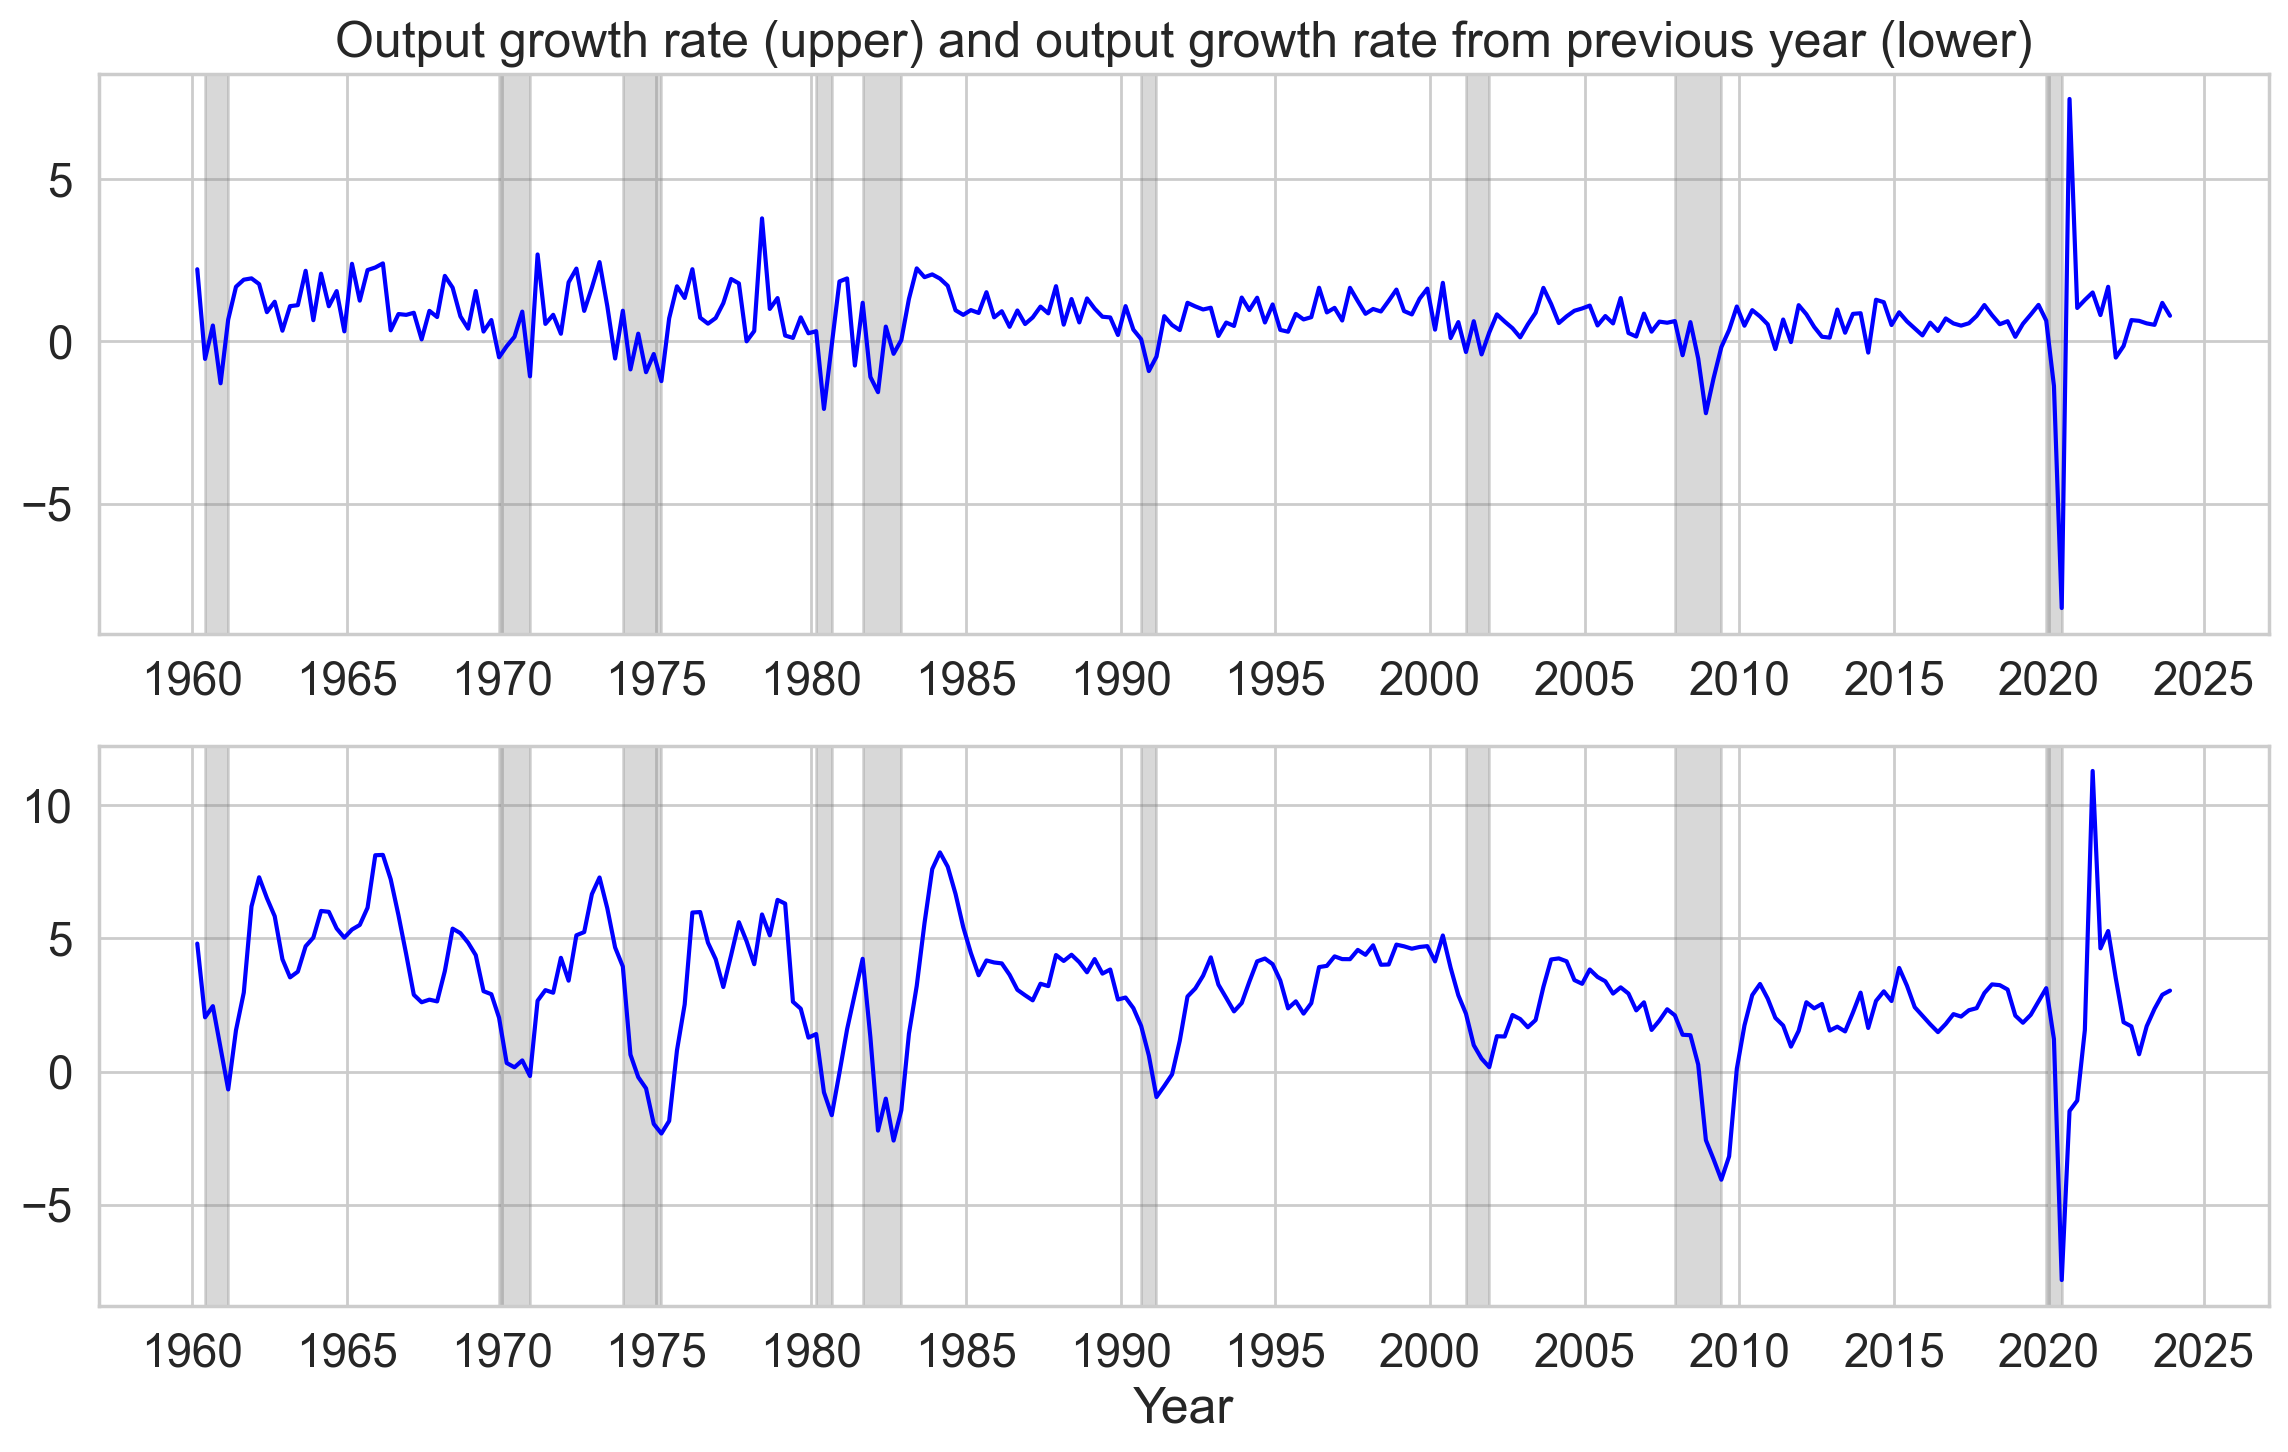

In [44]:
#gdp['ssadate'] = pd.to_datetime(gdp['ssadate'])

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8), nrows=2, ncols=1)

# Plot the growth rate of output
ax[0].plot(gdp.index, gdp["output_growth_pct"], color='blue')
ax[1].plot(gdp.index, gdp["output_growth_pct_last_year"], color='blue')

# Add recession shading
for start, end in business_cycles_dates.itertuples(index=False):
    ax[0].axvspan(start, end, color='grey', alpha=0.3)
    ax[1].axvspan(start, end, color='grey', alpha=0.3)

# Set the title and labels
ax[0].set_title('Output growth rate (upper) and output growth rate from previous year (lower)')
ax[1].set_xlabel('Year')

# Format the x-axis to show the year
ax[0].xaxis.set_major_locator(mdates.YearLocator(5))  # Get a tick every 5 years
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format tick to show year only
ax[1].xaxis.set_major_locator(mdates.YearLocator(5))  # Get a tick every 5 years
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format tick to show year only

# Show the plot
plt.show()


### Normalizing and preprocessing data

We must split our data into a training, validation and test data - train on training data, evaluate on validation data and test one last time on the test data. When evaluating the model we tune our hyper-parameters i.e. the network's weights using a feedback signal of the performance on the validation data. Tuning can however end with a model that overfits our validation data due to information leaks from the validation data to the training data. 

NB: Test data is meant to be as similar as possible to production data. 

Our data variables are on different scales and it is problematic to feed a neural network with values that take different ranges as is would make learning more difficult. We will therefore no feature-wise normalization for each feature in the data i.e. column containing input data. 

We subtract the mean of the feature and divide by the standard deviation. This centers the feature around 0 and gives it a unit standard deviation. Normalizing data for our test data is done using quantities from our train data. One should never use any quantities from the test data as the measure of generalization will be flawed. 

NB: The less training data one have, the worse overfitting will be. 



In [45]:
# define dataframe with target variable
target = filtered_gdp[['output_growth_pct']]

# Linear regression model

In this section we fit two linear models to our data:

- Linear regression with all features using LASSO
- AR(∞) using LASSO

We use the scikit-learn .predict() method to forecast our time series. The output is a point forecast that provides a single expected value for each input sample. It estimates the most likely future value of a variable at a specific future point in time. It takes the input features, applies the learned model coefficients (or decision rules, depending on the model type) to these features, and outputs a prediction for each instance in the input data. In Lasso Regression it uses the coefficients that haven't been shrunk to zero to compute the predictions. It is also known as a one-step forecast.

In [96]:
# setup
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

### Prepare data

In [97]:
data = pd.concat([target, regressors], axis=1)

# exclude covid-19
data = data[:end_date]

# specify split date
split_date = pd.to_datetime('2012-01-01')

# split data based on split date
train = data.loc[data.index < split_date]
test = data.loc[data.index >= split_date]

# get train and test data from data
X_train = train.drop('output_growth_pct', axis=1)
y_train = train['output_growth_pct']
X_test = test.drop('output_growth_pct', axis=1)
y_test = test['output_growth_pct']

In [98]:
# initialize the StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit on train data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape,X_test_scaled.shape)

(112, 732) (32, 732)


## Linear regression with all features using LASSO
### Fit model

In [99]:
# the time series cross-validation splitter
tscv = TimeSeriesSplit(n_splits=5)

# LassoCV with all options set
lasso_cv = LassoCV(
    alphas=np.logspace(-6, 1, 100),  # Adjust the range of alphas or set to None to use automatic selection
    cv=tscv,                         # Use time series cross-validation
    max_iter=1000,                   # Default is 1000, increase if convergence issues
    tol=0.0001,                      # Default tolerance for optimization
    n_alphas=100,                    # Used only if alphas is None
    fit_intercept=True,              # Whether to fit the intercept (default True)
    precompute='auto',               # Whether to use a precomputed Gram matrix to speed up calculations
    copy_X=True,                     # If True, X will be copied; else, it may be overwritten (default True)
    verbose=0,                       # Control verbosity (default 0)
    n_jobs=-1,                       # Number of CPUs to use during the cross validation (default 1)
    positive=False,                  # Restrict coefficients to be positive (default False)
    random_state=42,                 # Seed for the random number generator
    selection='cyclic'               # If set to 'random', a random coefficient is updated every iteration (default 'cyclic')
).fit(X_train_scaled, y_train)

# one-step/point forecast
y_pred_best = lasso_cv.predict(X_test_scaled)

# convert
predictions = np.array(y_pred_best)
date_range = pd.date_range(start=split_date, end='2020-01-01', freq='QS-MAR')
y_pred = pd.DataFrame({'y_pred': predictions}, index=date_range)

# evaluate
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
rmse = root_mean_squared_error(y_test, y_pred_best)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse) # note: this is sensitive to large outliers

Mean Squared Error: 0.19336085077471346
Mean Absolute Error: 0.3705336229900543
Root Mean Squared Error: 0.4397281555401171


Sammenlign med $\sigma^2$ (residual variancen = FEV) da den gerne skulle være nogenlunde lig med - inkluder variance i plot

Skal der nogle variable fra?

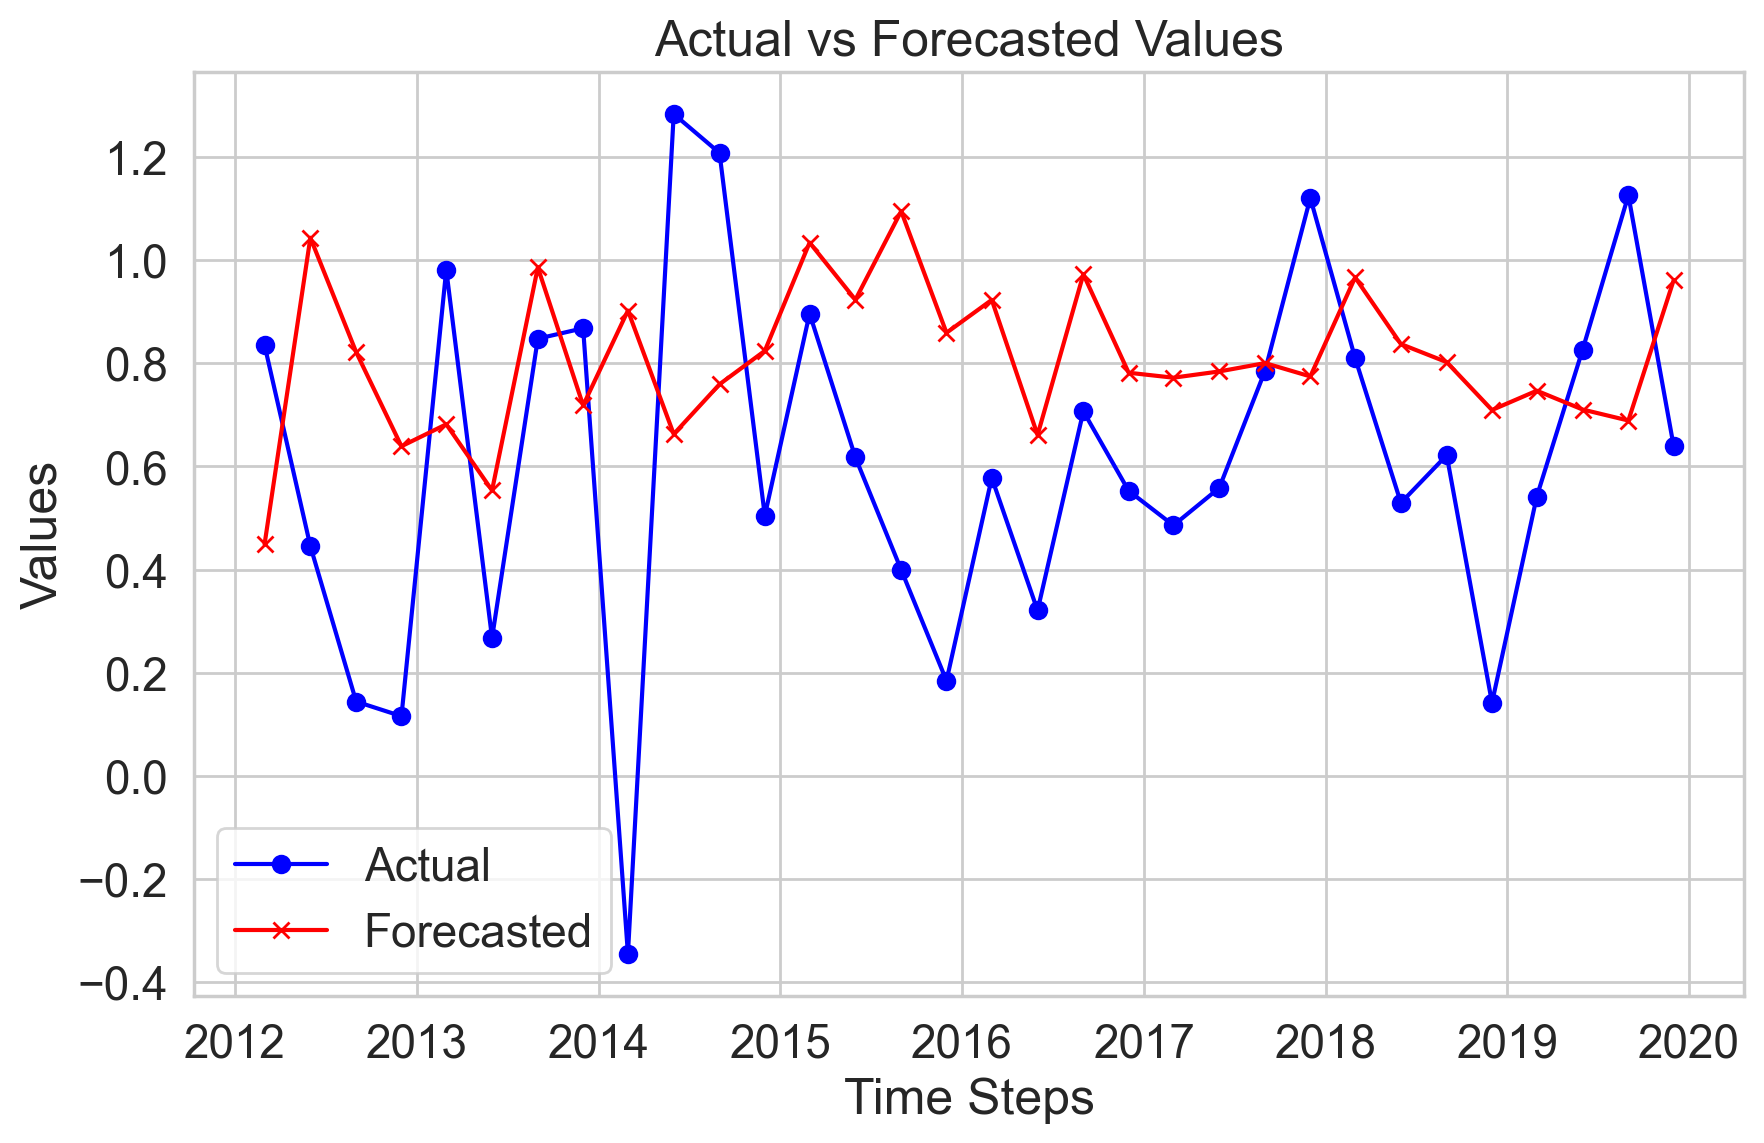

In [100]:
# Plotting the actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue', marker='o')
plt.plot(y_pred['y_pred'], label='Forecasted', color='red', marker='x')

# Adding title and labels
plt.title('Actual vs Forecasted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [101]:
selected_features = X_train.columns[lasso_cv.coef_ != 0].tolist()
selected_features

['A823RL1Q225SBEA_lag3',
 'AMDMUOx_lag3',
 'B020RE1Q156NBEA_lag2',
 'B021RE1Q156NBEA_lag4',
 'BAA_lag3',
 'CES9091000001_lag4',
 'CES9092000001_lag3',
 'CMRMTSPLx_lag1',
 'CUSR0000SA0L2_lag4',
 'CUSR0000SAD_lag2',
 'CUSR0000SAS_lag4',
 'DNDGRG3Q086SBEA_lag4',
 'DPIC96_lag1',
 'GDPCTPI_lag3',
 'GPDICTPI_lag1',
 'HOUST5F_lag2',
 'HOUST5F_lag4',
 'HWIURATIOx_lag2',
 'IMPGSC1_lag1',
 'IPB51110SQ_lag4',
 'IPB51222S_lag1',
 'IPBUSEQ_lag1',
 'IPFUELS_lag3',
 'IPNMAT_lag2',
 'LIABPIx_lag1',
 'LNS12032194_lag1',
 'M2REAL_lag4',
 'NASDAQCOM_lag1',
 'NIKKEI225_lag1',
 'NWPIx_lag2',
 'PCECC96_lag1',
 'PCESVx_lag1',
 'PERMIT_lag1',
 'PPIACO_lag3',
 'PRFIx_lag2',
 'PRFIx_lag4',
 'TLBSNNBBDIx_lag4',
 'USEHS_lag3',
 'USGOVT_lag3',
 'USINFO_lag1',
 'USSTHPI_lag1',
 'USWTRADE_lag2',
 'WPSID62_lag3']

## AR(∞) using LASSO

### Prepare data

In [102]:
# data
data = gdp[['output_growth_pct']]
data.rename(columns={'output_growth_pct': 'Y'}, inplace=True)

# generate lagged terms up to lag 20
for lag in range(1, 21):
    data[f'lag_{lag}'] = data['Y'].shift(lag)

# filter for correct period
data = data['1984-03-01':end_date]

In [103]:
# split data based on split date
train = data.loc[data.index < split_date]
test = data.loc[data.index >= split_date]

# get train and test data from data
X_train = train.drop('Y', axis=1)
y_train = train['Y']
X_test = test.drop('Y', axis=1)
y_test = test['Y']

# fit on train data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape,X_test_scaled.shape)

(112, 20) (32, 20)


### Fit model

In [104]:
# the time series cross-validation splitter
tscv = TimeSeriesSplit(n_splits=5)

# LassoCV
lasso_cv = LassoCV(
    alphas=np.logspace(-6, 1, 100),  # Adjust the range of alphas or set to None to use automatic selection
    cv=tscv,                         # Use time series cross-validation
    max_iter=1000,                   # Default is 1000, increase if convergence issues
    tol=0.0001,                      # Default tolerance for optimization
    n_alphas=100,                    # Used only if alphas is None
    fit_intercept=True,              # Whether to fit the intercept (default True)
    precompute='auto',               # Whether to use a precomputed Gram matrix to speed up calculations
    copy_X=True,                     # If True, X will be copied; else, it may be overwritten (default True)
    verbose=0,                       # Control verbosity (default 0)
    n_jobs=-1,                       # Number of CPUs to use during the cross validation (default 1)
    positive=False,                  # Restrict coefficients to be positive (default False)
    random_state=42,                 # Seed for the random number generator
    selection='cyclic'               # If set to 'random', a random coefficient is updated every iteration (default 'cyclic')
).fit(X_train_scaled, y_train)

# one-step forecast
y_pred_best = lasso_cv.predict(X_test_scaled)

# convert
predictions = np.array(y_pred_best )
date_range = pd.date_range(start=split_date, end='2020-01-01', freq='QS-MAR')
y_pred = pd.DataFrame({'y_pred': predictions}, index=date_range)

# evaluate
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
rmse = root_mean_squared_error(y_test, y_pred_best)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse) # note: this is sensitive to large outliers

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Mean Squared Error: 0.1595768835451909
Mean Absolute Error: 0.31253441234419055
Root Mean Squared Error: 0.3994707543052318


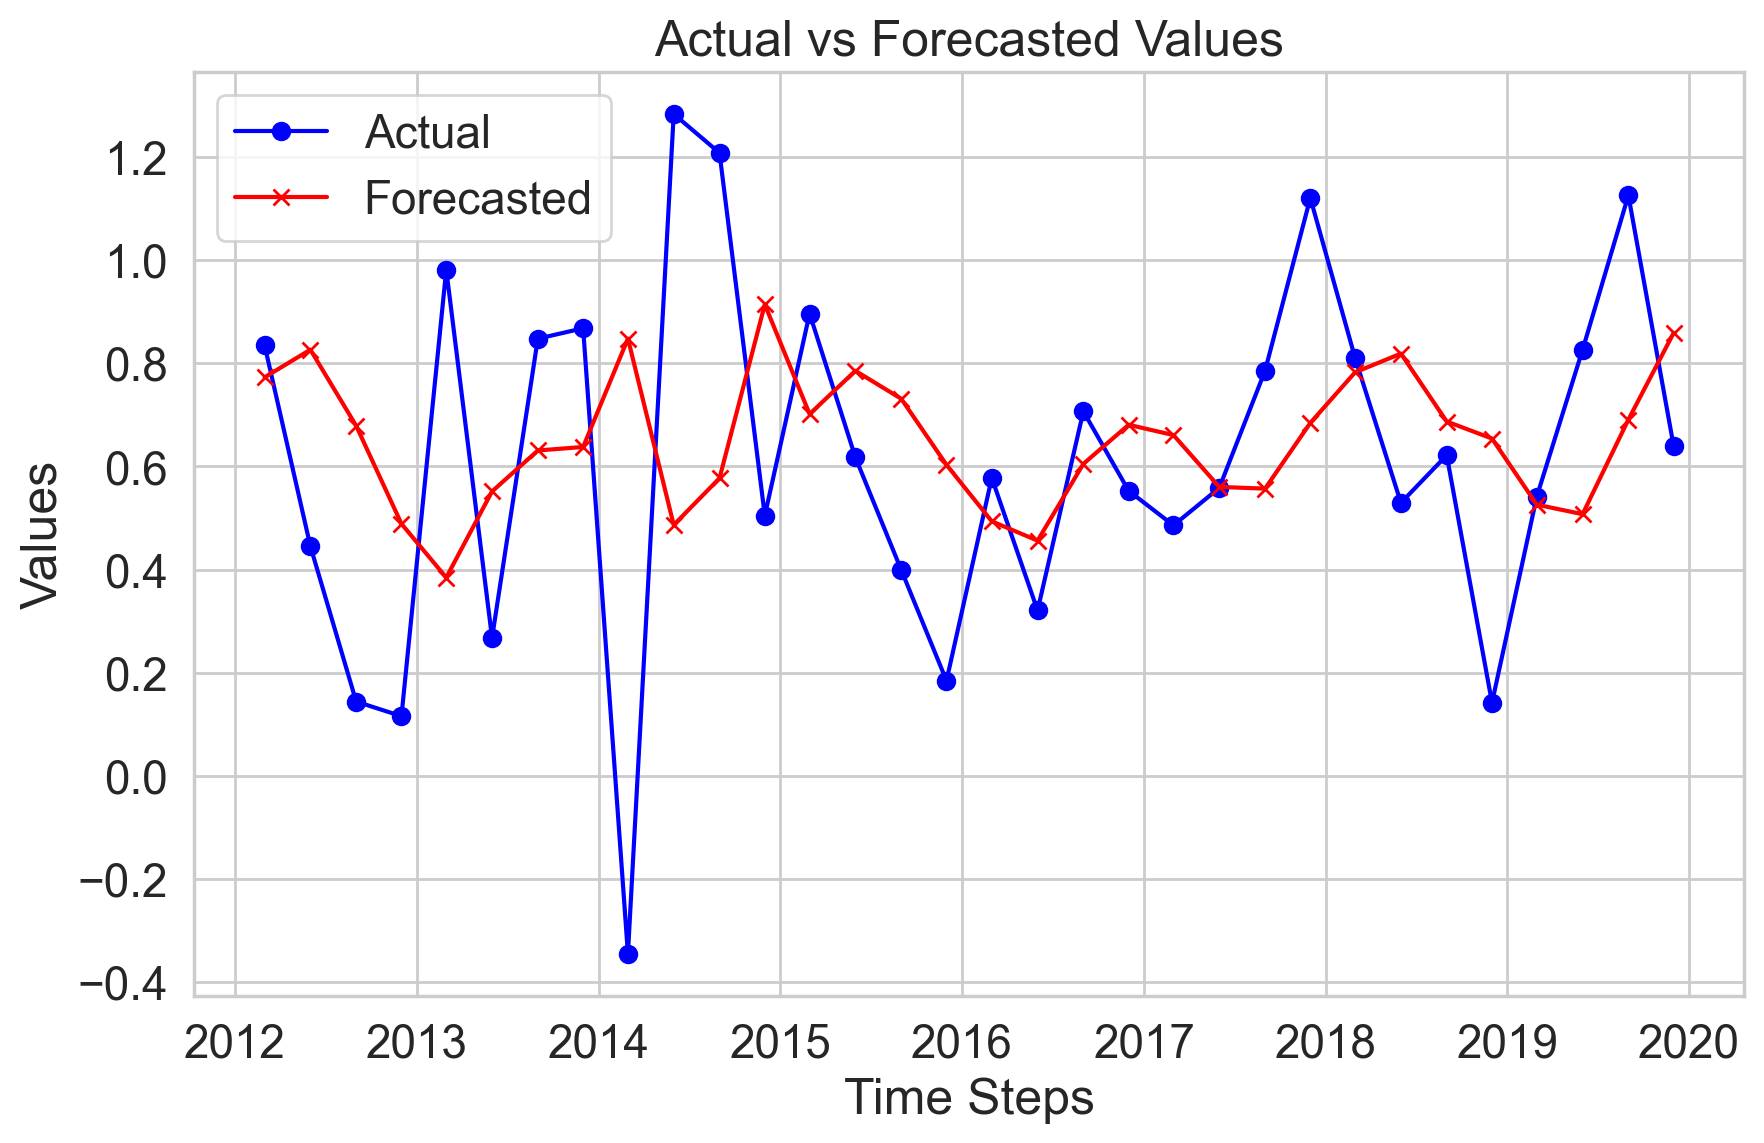

In [105]:
# Plotting the actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue', marker='o')
plt.plot(y_pred['y_pred'], label='Forecasted', color='red', marker='x')

# Adding title and labels
plt.title('Actual vs Forecasted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Deep learning (Recurrent Neural Networks)

We use a regression model to predict our continuous variable i.e. the output growth in the next quarters given data points about the US economy on a macro level.

## Prepare data

We’ll split it into training and test data:

In [106]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [111]:
regressors_ = regressors[selected_features]

data = pd.concat([target, regressors_], axis=1)

# exclude covid-19
data = data[:end_date]

# split data based on split date
train = data.loc[data.index < split_date]
test = data.loc[data.index >= split_date]

# get train and test data from data
X_train = train.drop('output_growth_pct', axis=1)
y_train = train['output_growth_pct']
X_test = test.drop('output_growth_pct', axis=1)
y_test = test['output_growth_pct']

In [112]:
time_steps = 20 # number of timesteps in the input sequence

X_train, y_train = create_dataset(X_train, y_train, time_steps)
X_test, y_test = create_dataset(X_test, y_test, time_steps)

# shapes: X=(n_samples, 10, n_features), y=(n_samples,)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(92, 20, 43) (92,)
(12, 20, 43) (12,)


### Modeling

The LSTM layer expects the number of time steps and the number of features to work properly. The rest of the model looks like a regular regression model. The most important thing to remember when training Time Series models is to not shuffle the data (the order of the data matters).

We compile the model with the mean squared error i.e. the square of the difference between the predictions and the targets. The method is widely used for regression problems. We also compute the mean absolute error i.e. the absolute value of the difference between the predictions and the targets. 

In [113]:
model = keras.Sequential([
    keras.layers.LSTM(
        units=50,  # Number of units in the LSTM layer (default: 128)
        activation='tanh',  # Activation function (default: 'tanh')
        recurrent_activation='sigmoid',  # Activation function for the recurrent step (default: 'sigmoid')
        use_bias=True,  # Whether the layer uses a bias vector (default: True)
        kernel_initializer='glorot_uniform',  # Initializer for the kernel weights matrix (default: 'glorot_uniform')
        recurrent_initializer='orthogonal',  # Initializer for the recurrent_kernel weights matrix (default: 'orthogonal')
        bias_initializer='zeros',  # Initializer for the bias vector (default: 'zeros')
        unit_forget_bias=True,  # If True, add 1 to the bias of the forget gate at initialization (default: True)
        kernel_regularizer=None,  # Regularizer function applied to the kernel weights matrix (default: None)
        recurrent_regularizer=None,  # Regularizer function applied to the recurrent_kernel weights matrix (default: None)
        bias_regularizer=None,  # Regularizer function applied to the bias vector (default: None)
        activity_regularizer=None,  # Regularizer function applied to the output of the layer (default: None)
        kernel_constraint=None,  # Constraint function applied to the kernel weights matrix (default: None)
        recurrent_constraint=None,  # Constraint function applied to the recurrent_kernel weights matrix (default: None)
        bias_constraint=None,  # Constraint function applied to the bias vector (default: None)
        dropout=0.0,  # Fraction of the units to drop for the linear transformation of the inputs (default: 0.0)
        recurrent_dropout=0.0,  # Fraction of the units to drop for the linear transformation of the recurrent state (default: 0.0)
        return_sequences=False,  # Whether to return the last output in the output sequence, or the full sequence (default: False)
        return_state=False,  # Whether to return the last state in addition to the output (default: False)
        go_backwards=False,  # If True, process the input sequence backwards and return the reversed sequence (default: False)
        stateful=False,  # If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch (default: False)
        time_major=False,  # If True, the inputs and outputs will be in time-major format (default: False)
        unroll=False,  # If True, the network will be unrolled, else a symbolic loop will be used (default: False)
        input_shape=(X_train.shape[1], X_train.shape[2])  # Shape of each input sample
    ),
    keras.layers.Dense(
        units=1,  # Number of units in the dense layer (default: 1)
        activation=None,  # Activation function to use (default: None)
        use_bias=True,  # Whether the layer uses a bias vector (default: True)
        kernel_initializer='glorot_uniform',  # Initializer for the kernel weights matrix (default: 'glorot_uniform')
        bias_initializer='zeros',  # Initializer for the bias vector (default: 'zeros')
        kernel_regularizer=None,  # Regularizer function applied to the kernel weights matrix (default: None)
        bias_regularizer=None,  # Regularizer function applied to the bias vector (default: None)
        activity_regularizer=None,  # Regularizer function applied to the output of the layer (default: None)
        kernel_constraint=None,  # Constraint function applied to the kernel weights matrix (default: None)
        bias_constraint=None  # Constraint function applied to the bias vector (default: None)
    )
])

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.001,  # Learning rate (default: 0.001)
        beta_1=0.9,  # Exponential decay rate for the 1st moment estimates (default: 0.9)
        beta_2=0.999,  # Exponential decay rate for the 2nd moment estimates (default: 0.999)
        epsilon=1e-07,  # Small constant for numerical stability (default: 1e-07)
        amsgrad=False,  # Whether to apply the AMSGrad variant of this algorithm (default: False)
        name='Adam'  # Optional name for the operations created when applying gradients (default: 'Adam')
    ),
    loss='mean_squared_error',  # Loss function (default: 'mean_squared_error')
    metrics=['mae']  # Metrics to monitor (default: None)
)

2024-05-14 13:52:55.529121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-14 13:52:55.548831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-14 13:52:55.552587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [114]:
history = model.fit(
    X_train,  # Training data
    y_train,  # Target data
    batch_size=16,  # Number of samples per gradient update (default: 32)
    epochs=30,  # Number of epochs to train the model (default: 1)
    verbose=1,  # Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch, default: 1)
    callbacks=None,  # List of callbacks to apply during training (default: None)
    validation_split=0.1,  # Fraction of the training data to be used as validation data (default: 0.0)
    validation_data=None,  # Data on which to evaluate the loss and any model metrics at the end of each epoch (default: None)
    shuffle=False,  # Whether to shuffle the training data before each epoch (default: True)
    class_weight=None,  # Optional dictionary mapping class indices to a weight for the class (default: None)
    sample_weight=None,  # Optional array of weights for the training samples (default: None)
    initial_epoch=0,  # Epoch at which to start training (useful for resuming a previous training run, default: 0)
    steps_per_epoch=None,  # Total number of steps (batches of samples) before declaring one epoch finished (default: None)
    validation_steps=None,  # Total number of validation steps (batches of samples) to draw before stopping (default: None)
    validation_batch_size=None,  # Number of samples per validation batch (default: None)
    validation_freq=1,  # Frequency of running validation (default: 1)
    max_queue_size=10,  # Maximum size for the generator queue (default: 10)
    workers=1,  # Number of processes to spin up when using process-based threading (default: 1)
    use_multiprocessing=False  # Whether to use process-based threading (default: False)
)

Epoch 1/30


2024-05-14 13:52:59.101740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-14 13:52:59.103844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-14 13:52:59.105279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/6 [====>.........................] - ETA: 11s - loss: 0.2312 - mae: 0.4134

2024-05-14 13:53:01.540069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-14 13:53:01.542145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-14 13:53:01.543754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 3s 129ms/step - loss: 0.5443 - mae: 0.5906 - val_loss: 0.2506 - val_mae: 0.4028
Epoch 2/30
6/6 [==============================] - 0s 9ms/step - loss: 0.5063 - mae: 0.5664 - val_loss: 0.2482 - val_mae: 0.4101
Epoch 3/30
6/6 [==============================] - 0s 21ms/step - loss: 0.4839 - mae: 0.5412 - val_loss: 0.2448 - val_mae: 0.4116
Epoch 4/30
6/6 [==============================] - 0s 19ms/step - loss: 0.4887 - mae: 0.5504 - val_loss: 0.2519 - val_mae: 0.4220
Epoch 5/30
6/6 [==============================] - 0s 13ms/step - loss: 0.4854 - mae: 0.5438 - val_loss: 0.2559 - val_mae: 0.4262
Epoch 6/30
6/6 [==============================] - 0s 10ms/step - loss: 0.4400 - mae: 0.4823 - val_loss: 0.2291 - val_mae: 0.3934
Epoch 7/30
6/6 [==============================] - 0s 19ms/step - loss: 0.4201 - mae: 0.4670 - val_loss: 0.2331 - val_mae: 0.3966
Epoch 8/30
6/6 [==============================] - 0s 14ms/step - loss: 0.4176 - mae: 0.4643 - val_loss: 0.23

### Evaluation/validation
We check to see if our model generalize to new data.
- K-fold cross validation
- Parameter tuning

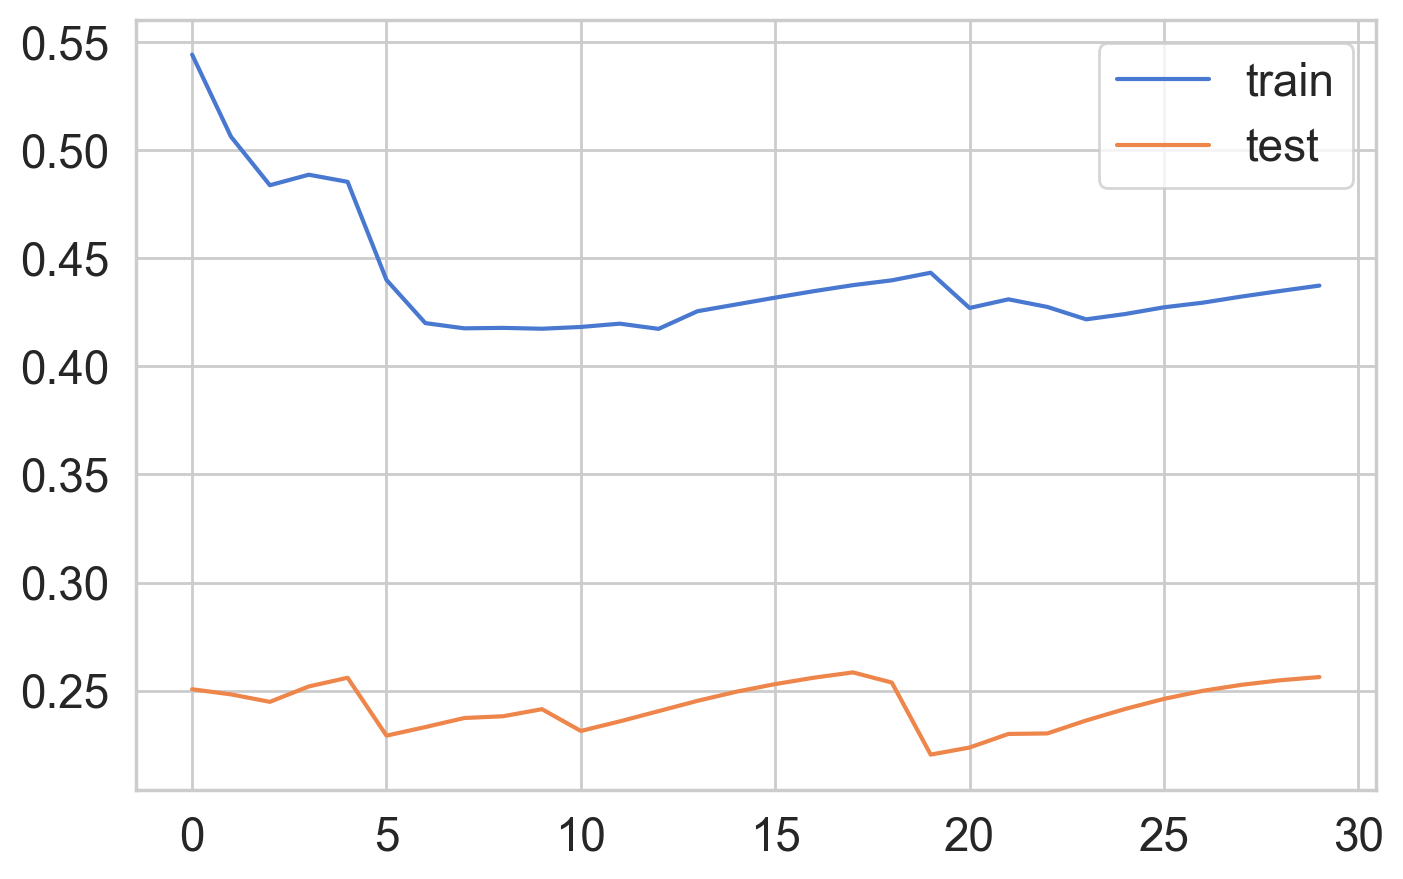

In [115]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [116]:
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 561ms/step


2024-05-14 13:53:13.782268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-14 13:53:13.790075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-14 13:53:13.791762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

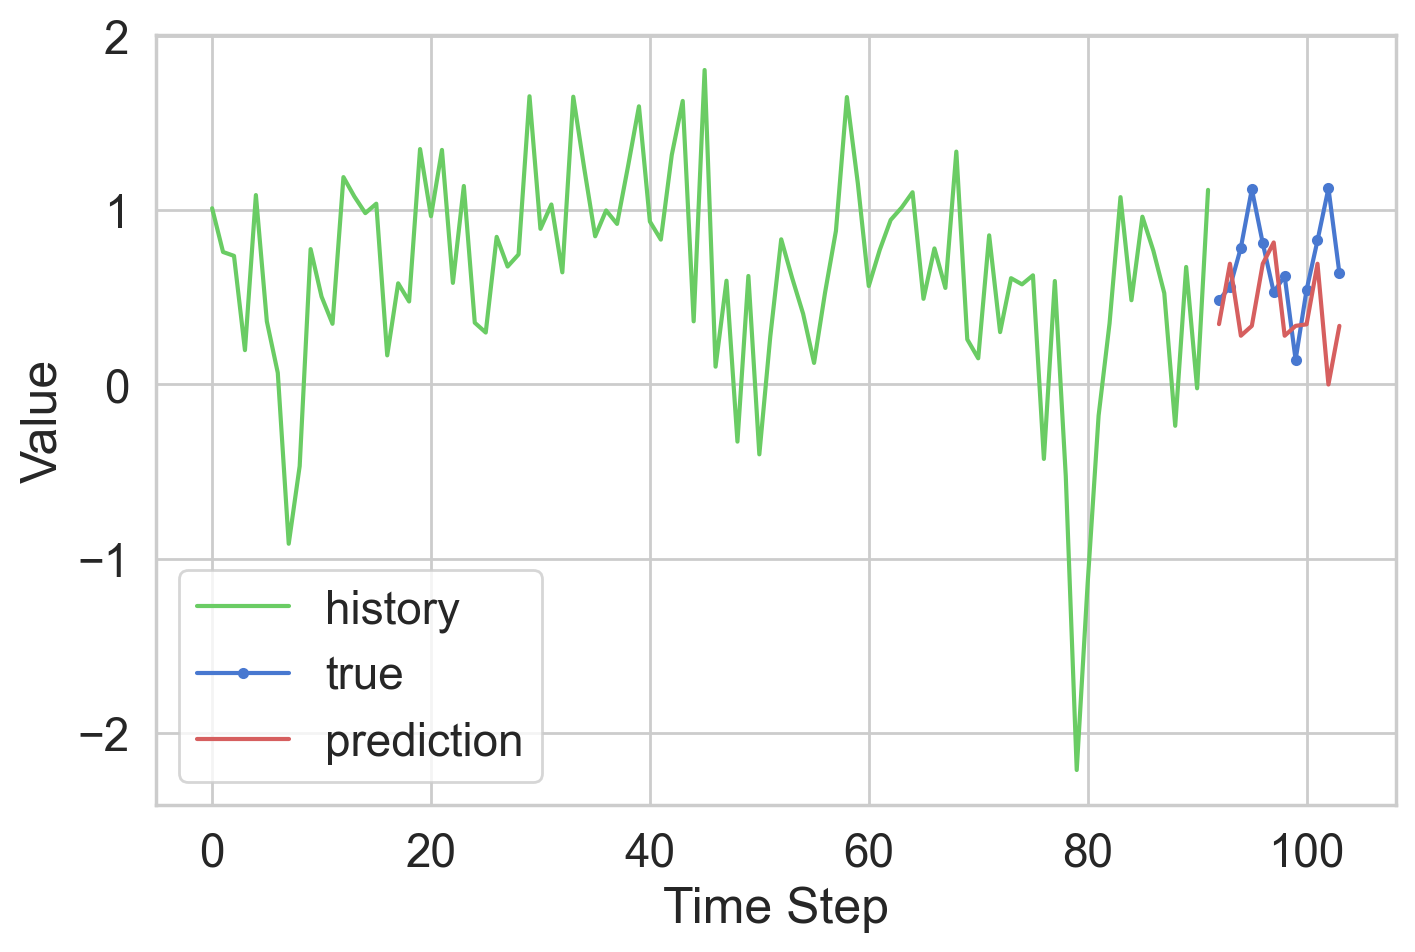

In [117]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

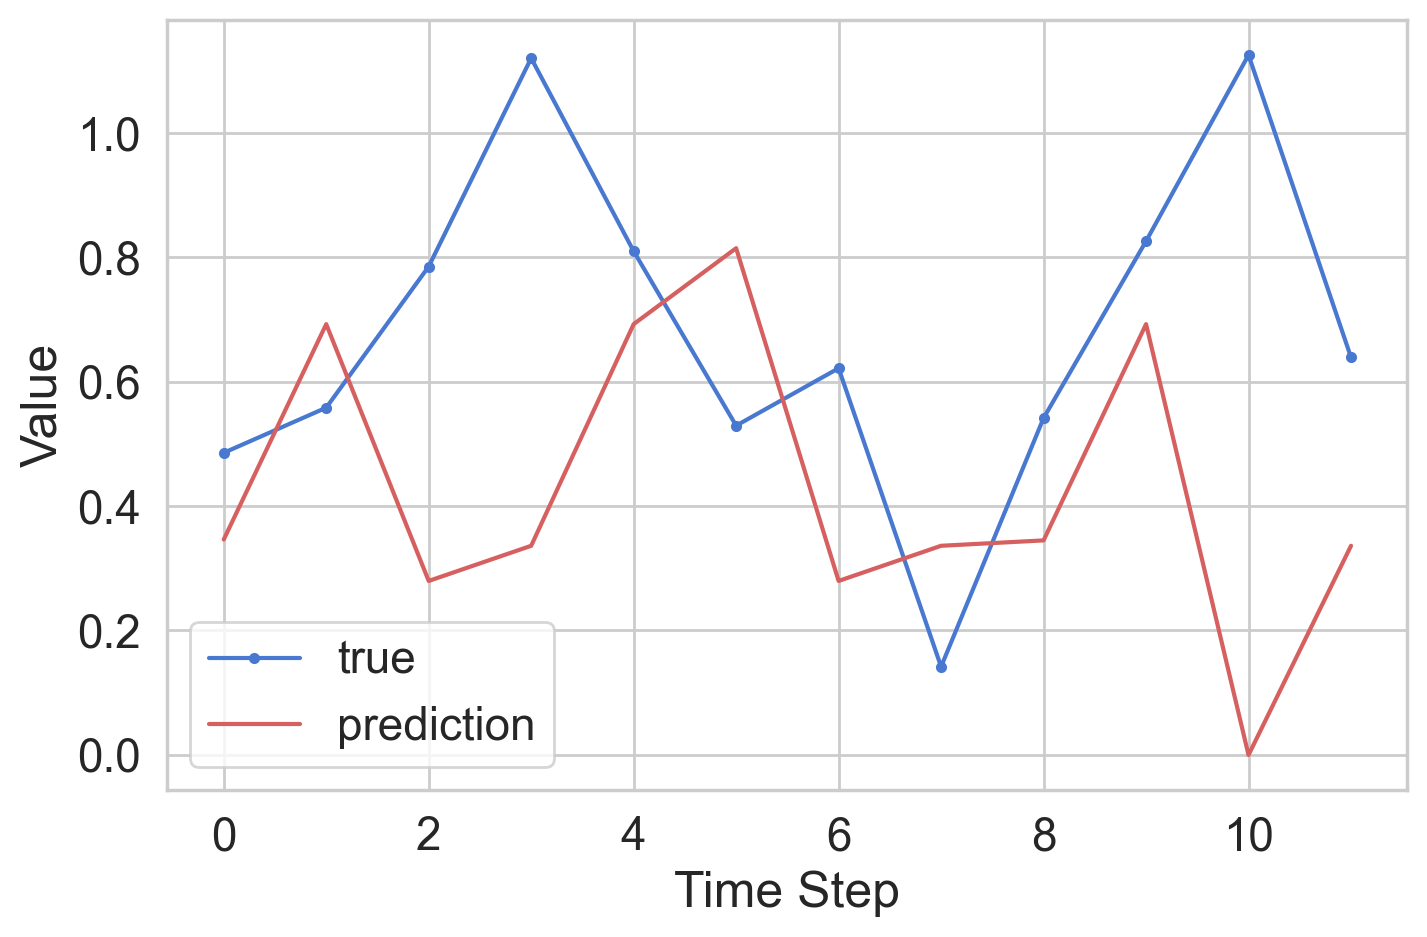

In [118]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [119]:
# evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse) # note: this is sensitive to large outliers

Mean Squared Error: 0.21470668025688985
Mean Absolute Error: 0.35533706838463114
Root Mean Squared Error: 0.4633645220092814


Questions for LSTM model:
- Should we only use selected features from linear regression (LASSO) model?